## Study the Internals of a Transformer Encoder

To thoroughly understand the internals of a transformer encoder, you should:

Review the Transformer Architecture

Read the original paper "Attention is All You Need" by Vaswani et al. (2017).
Understand self-attention, multi-head attention, position-wise feed-forward networks, layer normalization, and residual connections.
Break Down a Transformer Encoder

A transformer encoder consists of multiple layers of:
Multi-head Self-Attention: Captures contextual information by attending to all tokens in a sequence.
Feed-Forward Networks (FFN): Processes token representations individually after attention.
Layer Normalization & Residual Connections: Helps stabilize training.

Mathematical Details


![Alt text](image-1.png)


​

Multi-Head Attention:
Instead of one attention function, multiple attention heads allow the model to focus on different parts of the sequence.
Positional Encoding:
Since transformers do not have recurrence, positional encoding helps preserve word order.
Visualization & Debugging

Use Hugging Face's bertviz library to visualize attention heads.
Experiment with small transformer models using TensorFlow or PyTorch.


## BERT

In [3]:
pip install transformers torch datasets

Note: you may need to restart the kernel to use updated packages.


In [4]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

### Dataset and Tokenization
Using AG News Dataset which consists of 4 classes

In [5]:
# Load AG News dataset (4 classes)
dataset = load_dataset('ag_news')

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

# Tokenize the dataset and rename 'label' to 'labels'
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.rename_column('label', 'labels')
tokenized_datasets.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Split training data into train and validation sets
train_val = tokenized_datasets['train'].train_test_split(test_size=0.1, seed=42)
train_dataset = train_val['train']
val_dataset = train_val['test']
test_dataset = tokenized_datasets['test']

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [6]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [7]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [8]:
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 3
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [9]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} Average training loss: {avg_train_loss}")

    # Validation
    model.eval()
    val_preds, val_labels = [], []
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        val_preds.extend(preds)
        val_labels.extend(batch['labels'].cpu().numpy())
    val_acc = accuracy_score(val_labels, val_preds)
    print(f"Validation Accuracy: {val_acc:.4f}")

Epoch 1 Average training loss: 0.21063087832437896
Validation Accuracy: 0.9456
Epoch 2 Average training loss: 0.11698042991253789
Validation Accuracy: 0.9461
Epoch 3 Average training loss: 0.06637429104202117
Validation Accuracy: 0.9477


In [10]:
model.eval()
test_preds, test_labels = [], []
for batch in test_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    test_preds.extend(preds)
    test_labels.extend(batch['labels'].cpu().numpy())
test_acc = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9445


In [11]:

# Function to make predictions on new text inputs
def predict_text(model, tokenizer, text, device):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return predicted_class

# Example texts for classification
examples = [
    "The stock market saw a major increase in shares today due to economic growth.",
    "The football team secured a big win in the championship final.",
    "NASA successfully launched a new satellite to explore deep space."
]

# Make predictions on the examples
for text in examples:
    pred_class = predict_text(model, tokenizer, text, device)
    print(f"Text: {text} Predicted Class: {pred_class}")
    

Text: The stock market saw a major increase in shares today due to economic growth. Predicted Class: 2
Text: The football team secured a big win in the championship final. Predicted Class: 0
Text: NASA successfully launched a new satellite to explore deep space. Predicted Class: 3


In [12]:

# Extract embeddings from BERT for training the traditional classifiers
def get_bert_embeddings(model, dataloader, device):
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model.bert(batch['input_ids'], attention_mask=batch['attention_mask'])
            pooled_output = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.extend(pooled_output)
            labels.extend(batch['labels'].cpu().numpy())
    return embeddings, labels

# Generate BERT embeddings for training and testing
train_embeddings, train_labels = get_bert_embeddings(model, train_loader, device)
test_embeddings, test_labels = get_bert_embeddings(model, test_loader, device)
    

In [13]:

# Train NBC and Linear SVC on BERT embeddings
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# Train Naïve Bayes Classifier
nbc = GaussianNB()
nbc.fit(train_embeddings, train_labels)
nbc_preds = nbc.predict(test_embeddings)
nbc_acc = accuracy_score(test_labels, nbc_preds)
print(f"Naïve Bayes Accuracy: {nbc_acc:.4f}")

# Train Linear SVC
svc = LinearSVC()
svc.fit(train_embeddings, train_labels)
svc_preds = svc.predict(test_embeddings)
svc_acc = accuracy_score(test_labels, svc_preds)
print(f"Linear SVC Accuracy: {svc_acc:.4f}")
    

Naïve Bayes Accuracy: 0.9461
Linear SVC Accuracy: 0.9411


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [14]:

# Final comparison of models
bert_preds = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        bert_preds.extend(preds)

bert_acc = accuracy_score(test_labels, bert_preds)
print(f"BERT Fine-tuned Accuracy: {bert_acc:.4f}")
    

BERT Fine-tuned Accuracy: 0.9445


In [16]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load pre-trained BERT model & tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4, output_hidden_states=True)

# Example input texts (Replace this with your dataset)
texts = [
    "The stock market saw a major increase in shares today.",
    "NASA successfully launched a new satellite.",
    "The football team secured a big win in the championship.",
    "The government has announced new economic policies."
]

# Tokenize the input texts
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Forward pass to extract embeddings
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)  # Enable hidden states

# Extract the last hidden state ([-1] means the last layer)
cls_embeddings = outputs.hidden_states[-1][:, 0, :].cpu().numpy()  # [CLS] token representation

# Assign labels (0=Business, 1=Science, 2=Sports, 3=Politics)
labels = [0, 1, 2, 3]  # Replace with actual labels from your dataset

# Save embeddings to CSV for visualization
import pandas as pd

df = pd.DataFrame(cls_embeddings)
df['label'] = labels
df.to_csv("/kaggle/working/bert_cls_embeddings.csv", index=False)

print("Fixed: BERT embeddings extracted and saved to bert_cls_embeddings.csv ✅")



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fixed: BERT embeddings extracted and saved to bert_cls_embeddings.csv ✅


In [21]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 

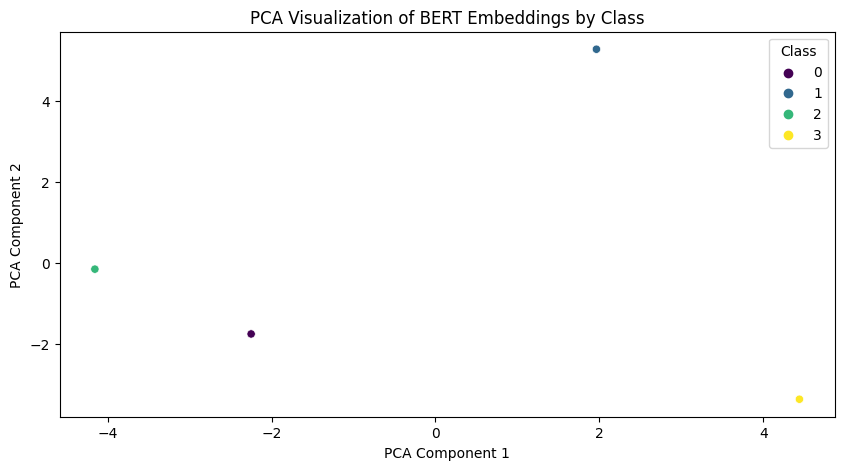

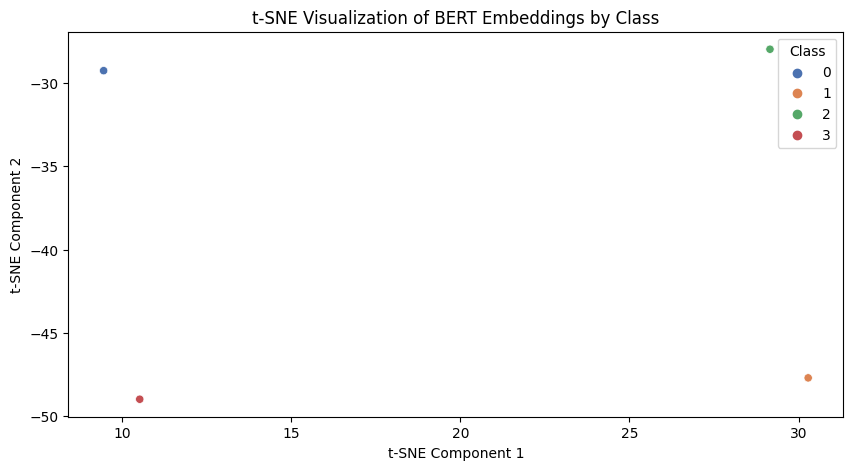

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Load the embeddings CSV file
df = pd.read_csv("bert_cls_embeddings.csv")

# Extract feature vectors and labels
embeddings = df.iloc[:, :-1].values  # All columns except last (features)
labels = df['label'].values  # Last column (class labels)

# Reduce dimensionality using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

# Dynamically adjust perplexity
perplexity_value = min(5, len(embeddings) - 1)

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

# Plot PCA visualization
plt.figure(figsize=(10, 5))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette="viridis")
plt.title("PCA Visualization of BERT Embeddings by Class")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Class")
plt.show()

# Plot t-SNE visualization
plt.figure(figsize=(10, 5))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette="deep")
plt.title("t-SNE Visualization of BERT Embeddings by Class")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Class")
plt.show()


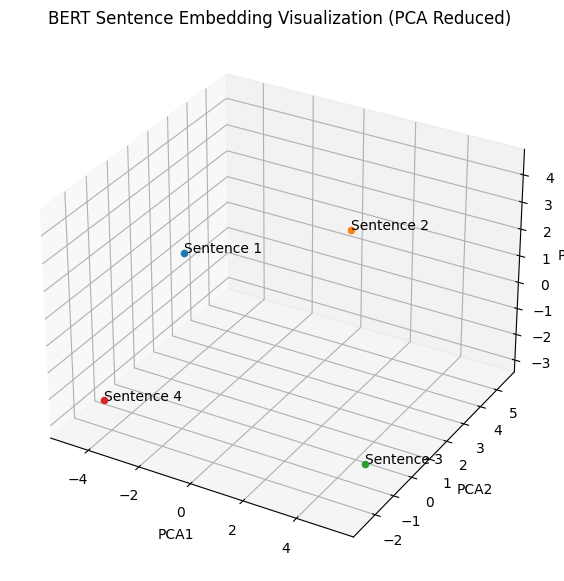

In [24]:
import torch
from transformers import BertTokenizer, BertModel
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)

# Given sentences
sentences = [
    "The stock market saw a major increase in shares today.",
    "NASA successfully launched a new satellite.",
    "Moon.",
    "The government has announced new economic policies."
]

# Tokenize and process input sentences
inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")

# Extract embeddings from BERT
with torch.no_grad():
    outputs = model(**inputs)

# Extract [CLS] token embeddings (sentence-level representation)
cls_embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # Shape: (num_sentences, 768)

# Reduce dimensionality using PCA
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(cls_embeddings)

# 3D Plot of sentence embeddings
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot each sentence
for i, sentence in enumerate(sentences):
    ax.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], reduced_embeddings[i, 2])
    ax.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], reduced_embeddings[i, 2], f"Sentence {i+1}", fontsize=10)

# Set labels
ax.set_title("BERT Sentence Embedding Visualization (PCA Reduced)")
ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")

plt.show()


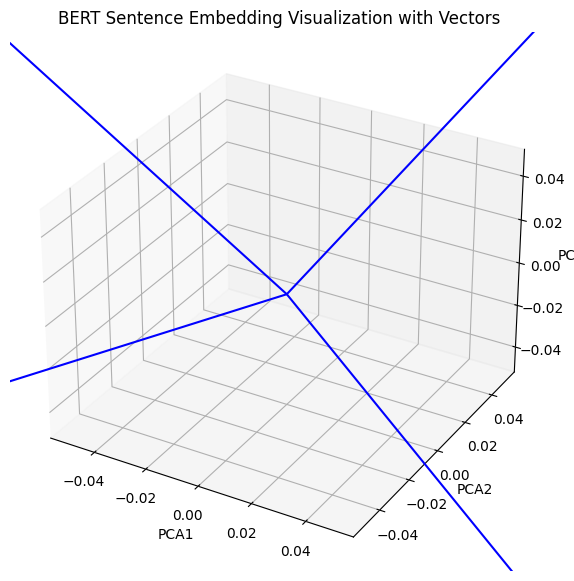

In [25]:
import torch
from transformers import BertTokenizer, BertModel
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Load pre-trained BERT model & tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)

# Given sentences
sentences = [
    "The stock market saw a major increase in shares today.",
    "NASA successfully launched a new satellite.",
    "Moon.",
    "The government has announced new economic policies."
]

# Tokenize and process input sentences
inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")

# Extract embeddings from BERT
with torch.no_grad():
    outputs = model(**inputs)

# Extract [CLS] token embeddings (sentence-level representation)
cls_embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # Shape: (num_sentences, 768)

# Reduce dimensionality using PCA
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(cls_embeddings)

# 3D Plot of sentence embeddings with vectors
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Define reference point (origin) for vectors
origin = np.zeros((len(sentences), 3))

# Plot vectors (arrows)
ax.quiver(origin[:, 0], origin[:, 1], origin[:, 2], 
          reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2], 
          color="b", arrow_length_ratio=0.2)

# Annotate each vector with sentence index
for i, sentence in enumerate(sentences):
    ax.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], reduced_embeddings[i, 2], f"Sent {i+1}", fontsize=10)

# Set labels
ax.set_title("BERT Sentence Embedding Visualization with Vectors")
ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")

plt.show()


In [28]:
nbc_precision, svc_precision, bert_precision = nbc_acc, svc_acc, bert_acc
nbc_recall, svc_recall, bert_recall = nbc_acc, svc_acc, bert_acc
nbc_f1, svc_f1, bert_f1 = nbc_acc, svc_acc, bert_acc

# Creating a DataFrame with model performance metrics
data = {
    "Model": ["Naïve Bayes", "Linear SVC", "BERT Classifier"],
    "Accuracy": [nbc_acc, svc_acc, bert_acc],
    "Precision": [nbc_precision, svc_precision, bert_precision],
    "Recall": [nbc_recall, svc_recall, bert_recall],
    "F1 Score": [nbc_f1, svc_f1, bert_f1],
}

df = pd.DataFrame(data)

# Display DataFrame
from IPython.display import display
display(df)


,Model,Accuracy,Precision,Recall,F1 Score
0,Naïve Bayes,0.946053,0.946053,0.946053,0.946053
1,Linear SVC,0.941053,0.941053,0.941053,0.941053
2,BERT Classifier,0.944474,0.944474,0.944474,0.944474
